**Градиентный спуск**

Среднеквадратичная ошибка имеет один минимум и непрерывна на всей области значений (то есть является выпуклой и гладкой), а значит в каждой ее точке можно посчитать частные производные.

Вспомним, что _градиентом_ функции $f$ называется $n$-мерный вектор из частных производных. 

$$ \nabla f(x_{1},...,x_{d}) = \left(\frac{\partial f}{\partial x_{i}}\right)^{d}_{i=1}.$$

При этом известно, что __градиент задает направление наискорейшего роста функции__. Значит, антиградиент будет показывать направление её скорейшего убывания, что будет полезно в задаче минимизации функционала ошибки.

Для решения задачи требуется определить некоторую стартовую точку и итерационно сдвигаться от неё в сторону антиградиента с определенным _шагом_ $\eta_{k}$, на каждом шаге пересчитывая градиент в точке, в которой мы находимся. Таким образом, имея начальный вектор весов $w^{0}$, $k$-й шаг градиентного спуска будет иметь вид

$$w^{k} = w^{k-1} - \eta_{k}\nabla Q(w^{k-1}, X).$$

Итерации следует продолжать, пока не наступает сходимость. Она определяется разными способами, но в даннном случае удобно определять как ситуацию, когда векторы весов от шага к шагу изменяются незначительно, то есть норма отклонения вектора весов на текущем шаге от предыдущего не привышает заданное значение $\varepsilon$:

$$||w^{k}-w^{k-1}|| < \varepsilon.$$

Начальный вектор весов $w_{0}$ также можно определять различными способами, обычно его берут нулевым или состоящим из случайных небольших чисел.

В случае многомерной регрессии (при количестве признаков больше 1) при оптимизации функционала ошибки 

$$Q(w, X) = \frac{1}{l}||Xw-y||^{2}\rightarrow \underset{w}{\text{min}}$$

формула вычисления градиента принимает вид

$$\nabla_{w}Q(w,X) = \frac{2}{l}X^{T}(Xw-y).$$

Задача линейной регрессии. Предсказание оценок или баллов полученных на экзамене.

In [640]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [641]:
# # реализуем функцию, определяющую среднеквадратичную ошибку
# def mserror(X, w, y):
#     y_pred = X.dot(w)
#     return (np.sum((y_pred - y)**2)) / len(y)

In [642]:
# Сгенерируем данные
X, Y, coef = datasets.make_regression(n_samples=10000, n_features=2, n_informative=2, n_targets=1, 
                                      noise=5, coef=True, random_state=42)
X[:, 0] *= 20       # Добавим шума в первый признак
display(X, Y, coef)

array([[-11.38296397,   1.59040357],
       [ 14.69755572,   0.49097495],
       [  4.01397389,   1.10623156],
       ...,
       [-37.72257408,   0.13807841],
       [-20.31757654,  -0.9933587 ],
       [ 23.15039212,   0.54658973]])

array([ -49.6854239 ,   73.63062887,   20.15499442, ..., -192.63317609,
       -106.45952324,  118.37024675])

array([98.57676058,  5.56663928])

In [643]:
X.shape

(10000, 2)

In [644]:
Y.shape

(10000,)

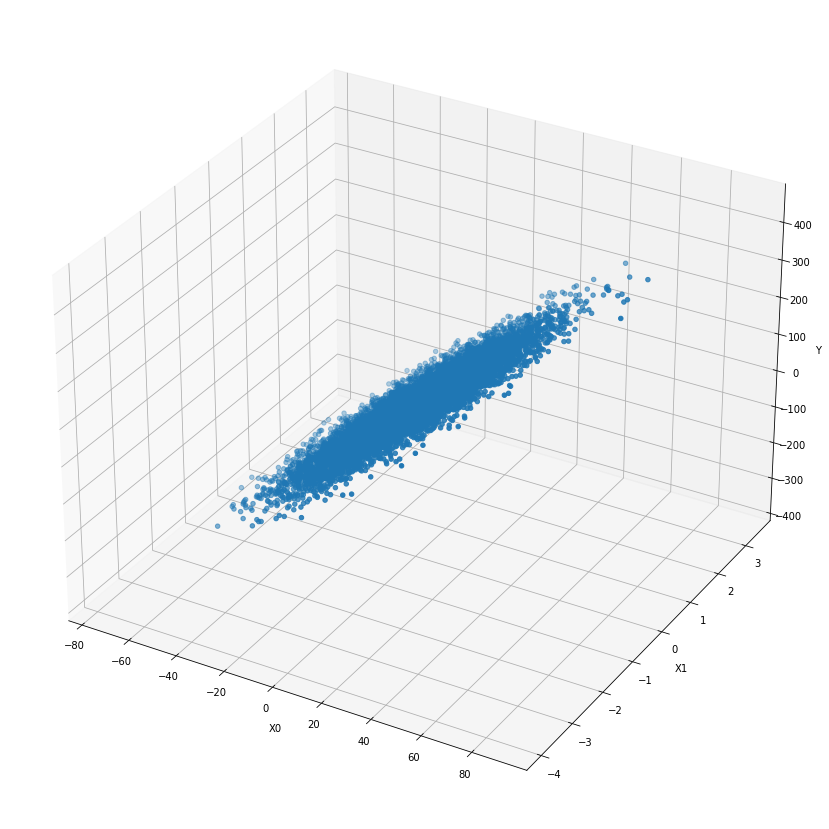

In [645]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y)

ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('Y')
plt.show()

In [646]:
def standard_scale(X):
  """
  Функция для стандартизации признаков
  """
  return (X - X.mean()) / X.std()

In [647]:
def get_standard_scale(X):
  X_st = X.copy().astype(np.float64)

  for i in range(X_st.shape[1]):
    X_st[:, i] = standard_scale(X_st[:, i])
  return X_st

In [648]:
X_st = get_standard_scale(X)

In [649]:
def get_mse(y, y_pred):
  """
  Вычисление MSE
  """
  error = np.mean((y - y_pred)**2)
  return error

In [650]:
def simple_gradient_descent(X, y, iterations, eta):
  """
  Классический градиентный спуск (GD)
  """
  W = np.random.randn(X.shape[1])
  n = X.shape[0]
  errors = []
  
  for i in range(iterations):
    y_pred = np.dot(X, W)
    err = get_mse(y, y_pred)
    errors.append(err)
    # градиент функции ошибки
    dQ = 2/n * X.T @ (y_pred - y)
    W -= eta * dQ
    if i % 100 == 0:
      print(f'Iter {i}: weights {W} error {err}')
  print(f'\nFinal MSE: {err:.6f}\n')

In [651]:
def gradient_descent(X, y, eta):
  """
  Классический градиентный спуск (GD) с остановкой по сходимости весов
  """
  W = np.random.randn(X.shape[1])
  W_init = W.copy()
  n = X.shape[0]

  # Список значений ошибок после каждой итерации
  errors = []

  # Список значений весов после каждой итерации
  W_list = []

  # Начальная разница весов
  weight_dist = np.inf

  # Критерий сходимости (разница весов, при которой алгоритм останавливается)
  min_weight_dist = 1e-6

  # Счётчик итераций
  iter_num = 0

  print(f'Number of objects = {n} \
      \nLearning rate = {eta} \
      \nInitial weights = {W} \n')
  
  while weight_dist > min_weight_dist:

    y_pred = np.dot(X, W)
    err = get_mse(y, y_pred)
    errors.append(err)

    # Вычисляем градиент функции ошибки  
    dQ = 2/n * X.T @ (y_pred - y)        
    new_W = W - eta * dQ

    # Вычисляем расстояние между весами по норме Эвклида 
    weight_dist = np.linalg.norm(new_W - W, ord=2)

    # Логирование процесса
    if iter_num % 100 == 0:
      print(f'Iteration {iter_num}: weights {W} error {err}')

    iter_num += 1
    W = new_W.copy()
    W_list.append(W)
  
  print(f'\nFinal MSE: {err:.6f}')
  print(f'Number of iterations: {iter_num}\n')
  W_list = np.array(W_list)

  return W_list, errors, iter_num, W_init

In [652]:
# Стохастический градиентный спуск (SGD)
def stohastic_gradient_descent(X, y, size, eta):
  """
  Стохастический градиентный спуск (SGD) с остановкой по сходимости весов
  """
  W = np.random.randn(X.shape[1])
  W_init = W.copy()
  n = X.shape[0]

  # Список значений ошибок после каждой итерации
  errors = []

  # Список значений весов после каждой итерации
  W_list = []

  # Начальная разница весов
  weight_dist = np.inf

  # Критерий сходимости (разница весов, при которой алгоритм останавливается)
  min_weight_dist = 1e-3

  # Счётчик итераций
  iter_num = 0

  print(f'Number of objects = {n} \
      \nLearning rate = {eta} \
      \nInitial weights = {W} \n')
  
  while weight_dist > min_weight_dist:
    
    inds = np.random.randint(n, size=size)
    y_pred = np.dot(X[inds], W)
    err = get_mse(y, np.dot(X, W))
    errors.append(err)

    dQ = 2 / y[inds].shape[0] * X[inds].T @ (y_pred - y[inds]) # градиент функции ошибки
    new_W = W - eta * dQ

    # Вычисляем расстояние между весами по норме Эвклида 
    weight_dist = np.linalg.norm(new_W - W, ord=1)
    
    # Логирование процесса
    if iter_num % 100 == 0:
      print(f'Iteration {iter_num}: weights {W} error {err}')
    
    iter_num += 1
    W = new_W.copy()
    W_list.append(W)
  
  print(f'\nFinal MSE: {err:.6f}')
  print(f'Number of iterations: {iter_num}\n')
  W_list = np.array(W_list)

  return W_list, errors, iter_num, W_init

In [653]:
%%time
simple_gradient_descent(X_st, Y, iterations=2000, eta=1e-2)

Iter 0: weights [ 2.9467037 -0.6678206] error 9454.853304276083
Iter 100: weights [85.32289567  4.70464247] error 191.24574538953004
Iter 200: weights [96.25255289  5.48960582] error 28.026328710395273
Iter 300: weights [97.70276115  5.60332278] error 25.15000093429706
Iter 400: weights [97.89519133  5.61967974] error 25.09930425461582
Iter 500: weights [97.92072628  5.62201829] error 25.09841054809151
Iter 600: weights [97.92411485  5.6223509 ] error 25.09839479070206
Iter 700: weights [97.92456454  5.62239799] error 25.098394512828534
Iter 800: weights [97.92462422  5.62240463] error 25.098394507927548
Iter 900: weights [97.92463214  5.62240556] error 25.09839450784109
Iter 1000: weights [97.92463319  5.62240569] error 25.098394507839565
Iter 1100: weights [97.92463333  5.62240571] error 25.098394507839537
Iter 1200: weights [97.92463335  5.62240571] error 25.09839450783954
Iter 1300: weights [97.92463335  5.62240571] error 25.098394507839537
Iter 1400: weights [97.92463335  5.622405

In [654]:
%%time
W_list_gd, err_gd, iter_gd, W_init_gd = gradient_descent(X_st, Y, eta=1e-2)

Number of objects = 10000       
Learning rate = 0.01       
Initial weights = [-1.66469588 -0.43232651] 

Iteration 0: weights [-1.66469588 -0.43232651] error 9975.873586667498
Iteration 100: weights [84.71152772  4.73181831] error 200.40121890595546
Iteration 200: weights [96.17149568  5.49267222] error 28.187238740227464
Iteration 300: weights [97.69201384  5.60365816] error 25.152829469925724
Iteration 400: weights [97.89376629  5.61971477] error 25.099353984392433
Iteration 500: weights [97.92053732  5.62202168] error 25.098411422567196
Iteration 600: weights [97.92408979  5.62235118] error 25.098394806082023
Iteration 700: weights [97.92456122  5.622398  ] error 25.09839451309908

Final MSE: 25.098395
Number of iterations: 720

CPU times: user 128 ms, sys: 103 ms, total: 231 ms
Wall time: 125 ms


In [655]:
print(W_list_gd)

[[ 3.26697183e-01 -3.17704631e-01]
 [ 2.27826983e+00 -2.05245760e-01]
 [ 4.19081834e+00 -9.49092256e-02]
 ...
 [ 9.79245832e+01  5.62240029e+00]
 [ 9.79245842e+01  5.62240040e+00]
 [ 9.79245852e+01  5.62240050e+00]]


In [656]:
%%time
W_list_sgd, err_sgd, iter_sgd, W_init_sgd  = stohastic_gradient_descent(X_st, Y, size=1, eta=1e-2)

Number of objects = 10000       
Learning rate = 0.01       
Initial weights = [ 0.89648919 -0.54907686] 

Iteration 0: weights [ 0.89648919 -0.54907686] error 9473.754426950418
Iteration 100: weights [89.49014553  4.61809794] error 97.19255763602811
Iteration 200: weights [96.92496846  5.12139822] error 26.345477726765758

Final MSE: 25.118571
Number of iterations: 254

CPU times: user 52 ms, sys: 56 ms, total: 108 ms
Wall time: 73.2 ms


In [657]:
def visualization_mse(iter_gd, iter_sgd, err_gd, err_sgd):
  """
  Функция визуализации изменения ошибки после каждой итерации для GD и SGD
  """
  plt.figure(figsize=(14, 10))
  plt.plot(range(iter_gd), err_gd, color='b', label='GD', alpha=0.8)
  plt.plot(range(iter_sgd), err_sgd, color='r',label='SGD', alpha=0.8)
  plt.title('Зависимость MSE от количества итераций')
  plt.xlabel('Число итераций')
  plt.ylabel('MSE')
  plt.xlim(0, 200)
  plt.legend()

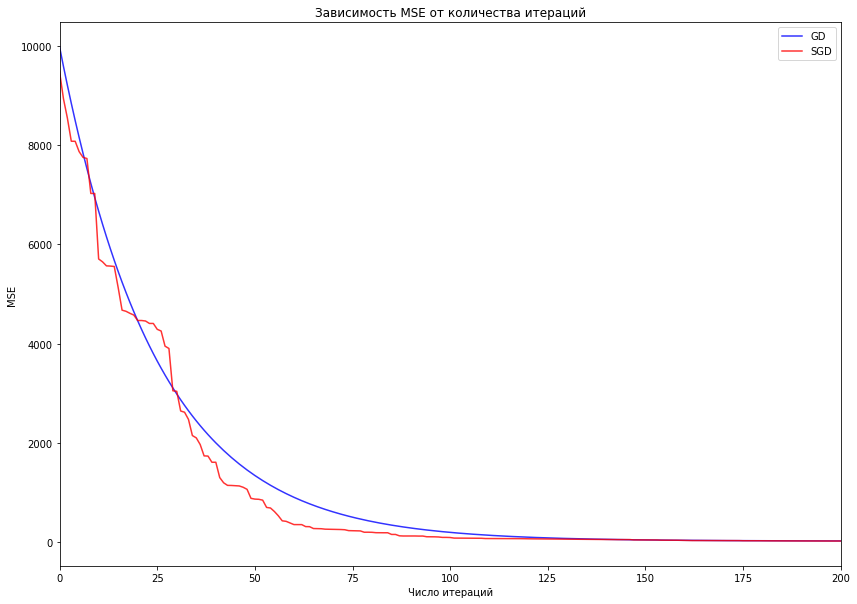

In [658]:
visualization_mse(iter_gd, iter_sgd, err_gd, err_sgd)

In [659]:
def visualization_weigths(W_init_gd, W_init_sgd, W_list_gd, W_list_sgd):
  """
  Функция визуализации изменения весов для GD и SGD
  """
  plt.figure(figsize=(25, 10))
  plt.title('Изменение весов')
  plt.xlabel(r'$w_1$')
  plt.ylabel(r'$w_2$')

  # Красной точкой обозначены веса, сгенерированные в начале алгоритма
  plt.scatter(W_init_gd[0], W_init_gd[1], c='r')
  plt.scatter(W_init_sgd[0], W_init_sgd[1], c='r')

  # Веса для GD
  plt.scatter(W_list_gd[:, 0], W_list_gd[:, 1])
  plt.plot(W_list_gd[:, 0], W_list_gd[:, 1], label='GD')

  # Веса для SGD
  plt.scatter(W_list_sgd[:, 0], W_list_sgd[:, 1])
  plt.plot(W_list_sgd[:, 0], W_list_sgd[:, 1], label='SGD')

  plt.legend(loc='upper left')
  plt.show()

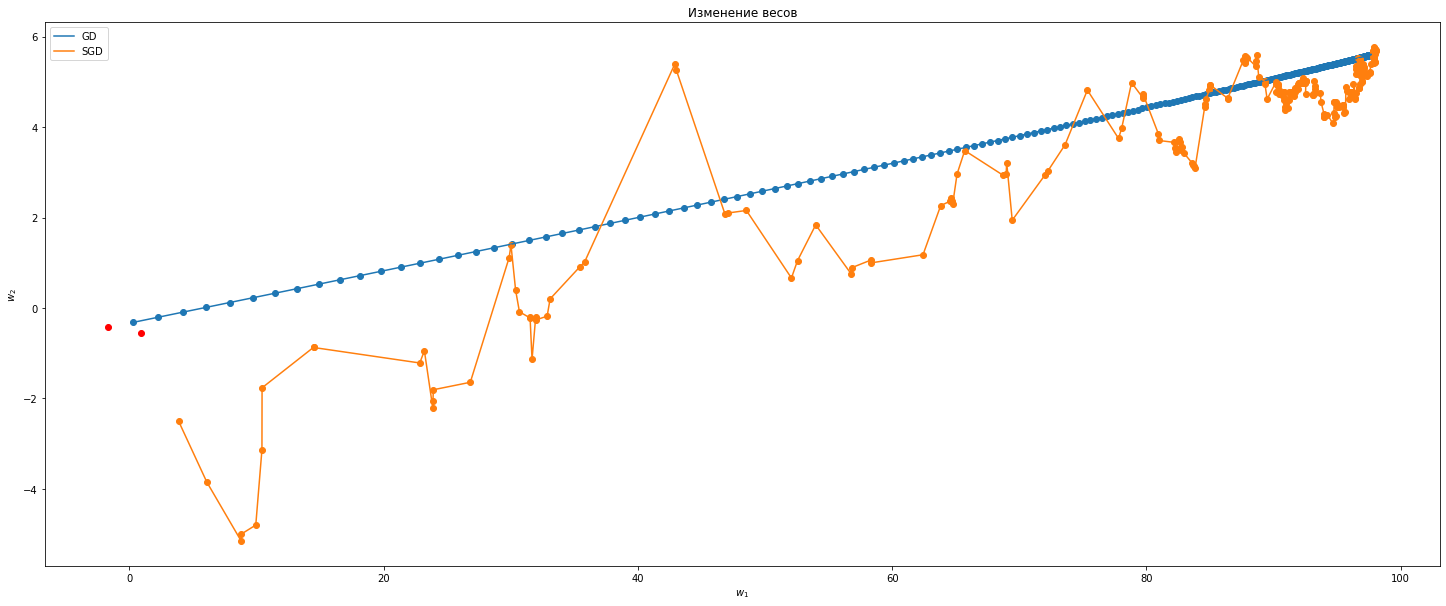

In [660]:
visualization_weigths(W_init_gd, W_init_sgd, W_list_gd, W_list_sgd)

In [661]:
reg = make_pipeline(StandardScaler(), 
                    SGDRegressor(max_iter=1000, tol=1e-3))

In [663]:
reg.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [664]:
reg.predict(X)

array([ -47.19835808,   75.04254013,   25.88723455, ..., -184.94062028,
       -105.57973137,  116.95807939])

In [665]:
reg.score(X, Y)

0.9974492153437657